In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

In [2]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_dataset.transform=transform
test_dataset.transform=transform

m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Valid Loader: {}".format(len(val_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Valid Loader: {}".format(len(val_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

Batches in Train Loader: 375
Batches in Valid Loader: 94
Batches in Test Loader: 79
Examples in Train Loader: 48000
Examples in Valid Loader: 12000
Examples in Test Loader: 10000


In [9]:
from torch.nn.modules import padding
class ConvNet(nn.Module):
  def __init__(self, h1 = 96):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.dropout1 = nn.Dropout(p=0.5)

    self.fc1 = nn.Linear(32 * 7 * 7, h1)
    self.dropout2 = nn.Dropout(p=0.1)
    self.fc2 = nn.Linear(h1, 10)

  def forward(self, x):

    # Each convolutional layer is followed by the ReLU activation function and maxpooling layer.
    x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2))
    x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2))
    x = self.dropout1(x)

    # The view function reshapes the data into a one-dimensional array (flattens the data), that will be passed to the linear layer.
    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.dropout2(x)

    return self.fc2(x)

In [10]:
dev = "cuda:0" if torch.cuda.is_available() else "cpu"
print(dev)
device = torch.device(dev)

cuda:0


In [11]:
torch.manual_seed(0)

model = ConvNet()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()

In [12]:
NUM_EPOCH = 10

In [13]:
def train(model, criterion, optimizer):
  history={'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  for epoch in range(NUM_EPOCH):

    model.train()
    train_loss, train_correct = 0.0, 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      
      # The gradient is cleared to be sure we don’t accumulate other values
      optimizer.zero_grad()

      output = model(images)
      loss = criterion(output, labels)

      # Performs Back Propagation and calculates the gradient based on the loss
      loss.backward()

      # This is always after the computation of the gradient. It iterates over all the parameters and updates their values.
      optimizer.step()

      train_loss += loss.item() * images.size(0)
      scores, preds = torch.max(output.data, 1)
      train_correct += (preds == labels).sum().item()

    model.eval()
    val_loss, val_correct = 0.0, 0
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)

      output = model(images)
      loss = criterion(output, labels)

      val_loss += loss.item() * images.size(0)
      scores, preds = torch.max(output.data, 1)
      val_correct += (preds == labels).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler)*100
    val_loss = val_loss / len(val_loader.sampler)
    val_acc = val_correct / len(val_loader.sampler) * 100

    print("Epoch:{}/{} \t AVERAGE TL:{:.4f} AVERAGE VL:{:.4f} \t AVERAGE TA:{:.2f} %  AVERAGE VA:{:.2f} %".format(epoch + 1, NUM_EPOCH,
                                                                                         train_loss,
                                                                                         val_loss,
                                                                                         train_acc,
                                                                                        val_acc))
    
    history['train_loss'].append(train_loss)    
    history['val_loss'].append(val_loss)  
    history['train_acc'].append(train_acc)  
    history['val_acc'].append(val_acc)

In [14]:
train(model, criterion, optimizer)

Epoch:1/10 	 AVERAGE TL:0.2617 AVERAGE VL:0.0755 	 AVERAGE TA:91.83 %  AVERAGE VA:97.58 %
Epoch:2/10 	 AVERAGE TL:0.0841 AVERAGE VL:0.0541 	 AVERAGE TA:97.36 %  AVERAGE VA:98.34 %
Epoch:3/10 	 AVERAGE TL:0.0630 AVERAGE VL:0.0432 	 AVERAGE TA:97.96 %  AVERAGE VA:98.75 %
Epoch:4/10 	 AVERAGE TL:0.0521 AVERAGE VL:0.0379 	 AVERAGE TA:98.33 %  AVERAGE VA:98.88 %
Epoch:5/10 	 AVERAGE TL:0.0446 AVERAGE VL:0.0363 	 AVERAGE TA:98.54 %  AVERAGE VA:98.96 %
Epoch:6/10 	 AVERAGE TL:0.0416 AVERAGE VL:0.0366 	 AVERAGE TA:98.63 %  AVERAGE VA:99.00 %
Epoch:7/10 	 AVERAGE TL:0.0379 AVERAGE VL:0.0361 	 AVERAGE TA:98.74 %  AVERAGE VA:98.92 %
Epoch:8/10 	 AVERAGE TL:0.0346 AVERAGE VL:0.0348 	 AVERAGE TA:98.84 %  AVERAGE VA:99.06 %
Epoch:9/10 	 AVERAGE TL:0.0315 AVERAGE VL:0.0344 	 AVERAGE TA:99.00 %  AVERAGE VA:99.08 %
Epoch:10/10 	 AVERAGE TL:0.0290 AVERAGE VL:0.0352 	 AVERAGE TA:99.04 %  AVERAGE VA:99.09 %


In [15]:
def eval(model, criterion):
  correct, total, test_loss = 0, 0, 0

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      output = model(images)
      loss = criterion(output, labels)

      test_loss += loss.item() * images.size(0)
      _, preds = torch.max(output.data, 1)
      correct += (preds == labels).sum().item()
      total += labels.size(0)

  test_loss = test_loss / len(test_loader.sampler)
  print('Accuracy of the network on the test images: {:.2f} %%'.format(100 * correct / total))
  print('Loss of the network on the test images: {:.4f}'.format(test_loss))

In [16]:
eval(model, criterion)

Accuracy of the network on the test images: 99.15 %%
Loss of the network on the test images: 0.0257


Visualizing The Filters

---



In [17]:
def get_model_weights(model):
  model_weights, conv_layers = [], []
  model_children = list(model.children())

  # counter to keep track of the conv layers
  counter = 0

  # Append all conv layers and their respective weights to the list
  for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
      counter += 1
      model_weights.append(model_children[i].weight)
      conv_layers.append(model_children[i])

    elif type(model_children[i]) == nn.Sequential:
      for j in range(len(model_children[i])):
        for child in model_children[i][j].children():
          if type(child) == nn.Conv2d:
            counter += 1
            model_weights.append(child.weight)
            conv_layers.append(child)

  print(f"Total convolutional layers: {counter}")

  return model_weights, conv_layers

In [18]:
model_weights, _ = get_model_weights(model)

Total convolutional layers: 2


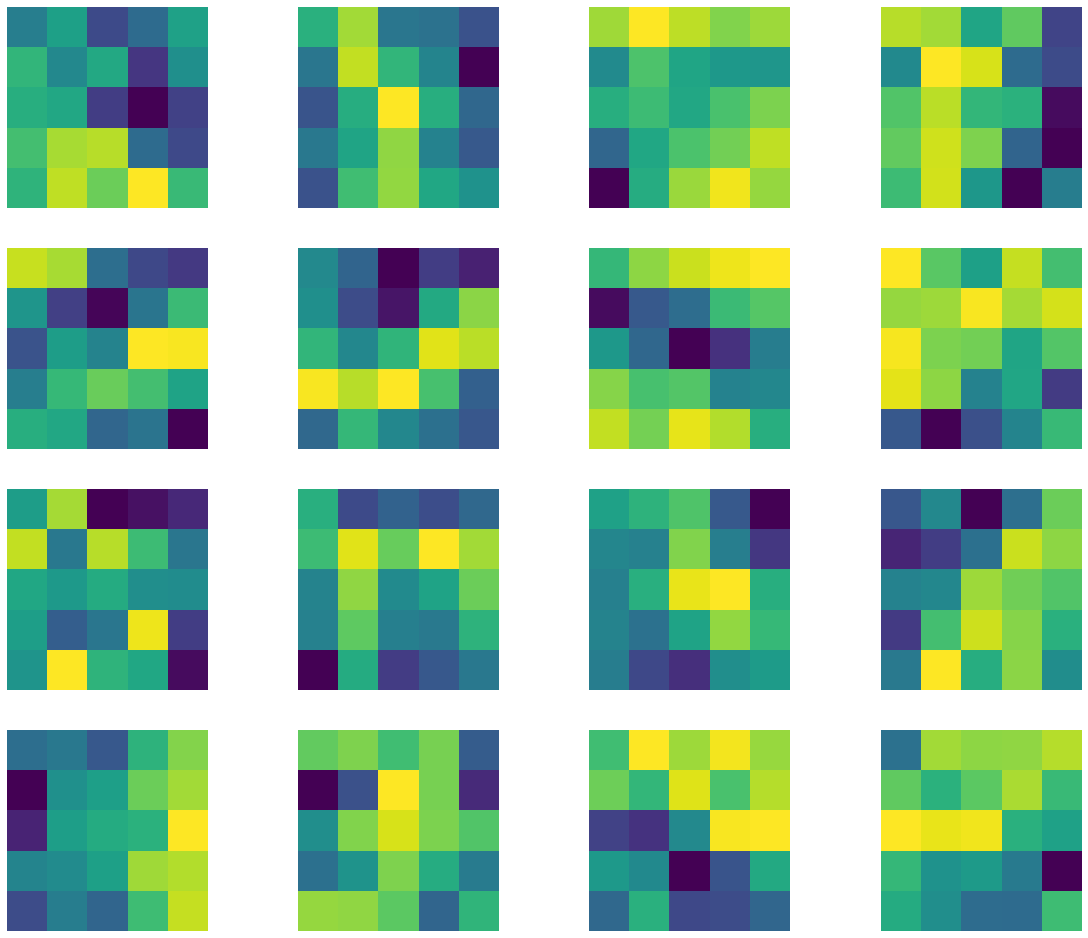

In [19]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

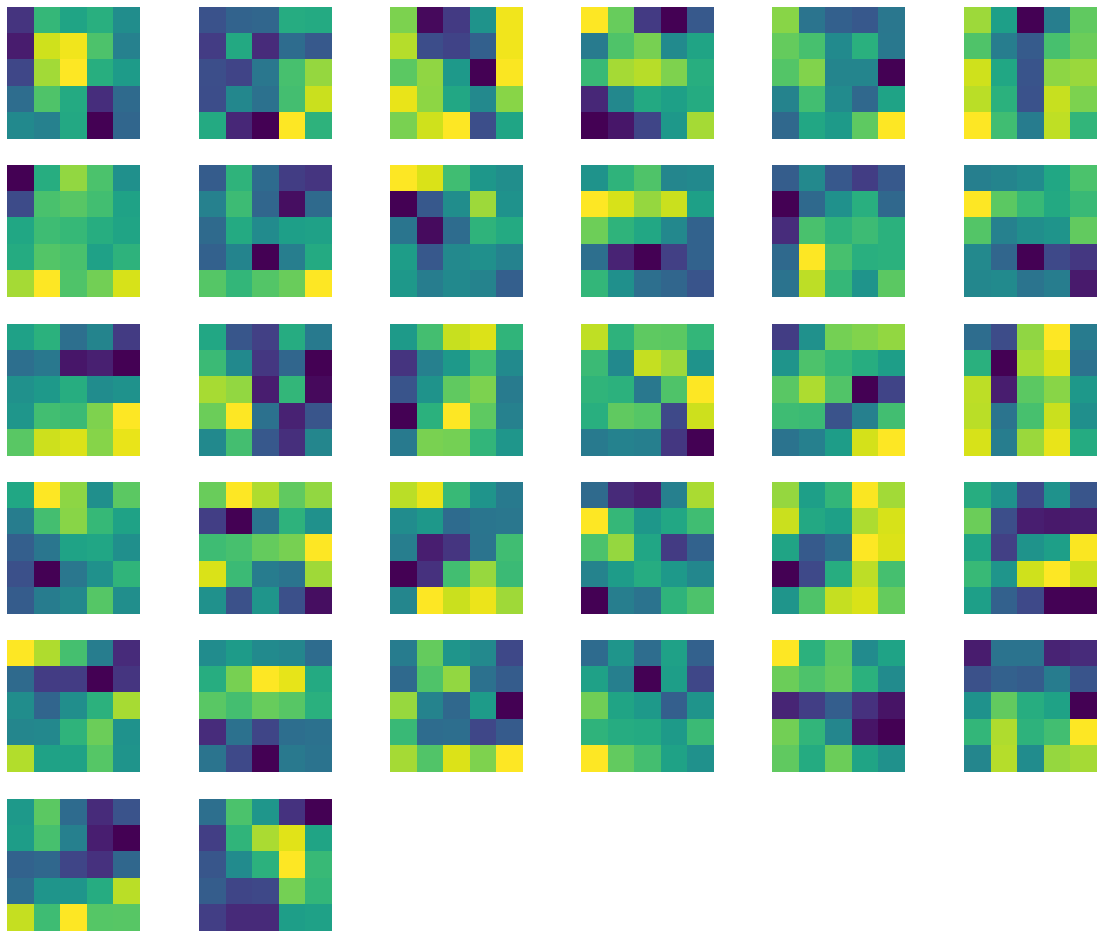

In [20]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(6, 6, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

Visualizing the Feature Maps

---



In [21]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

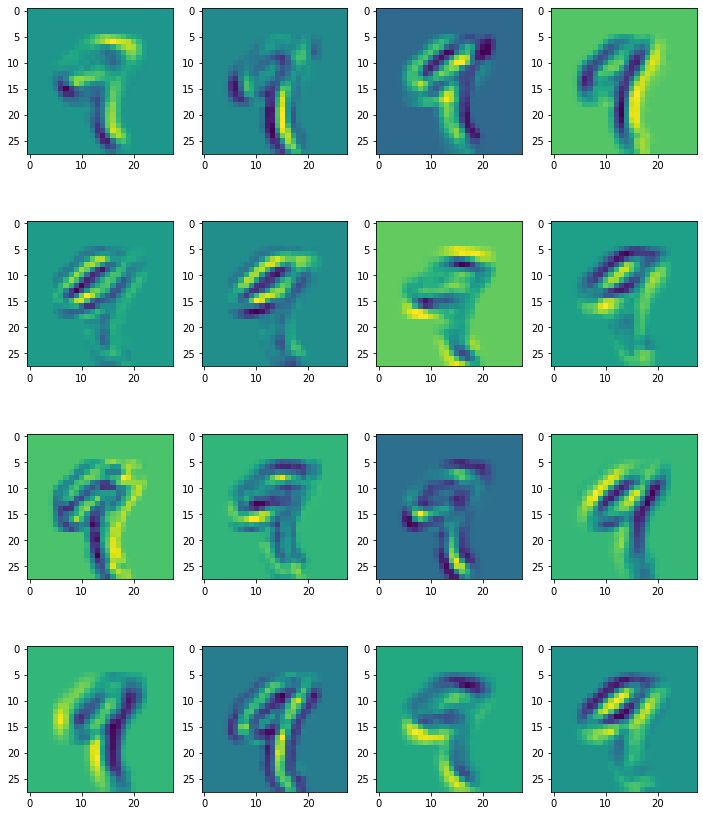

In [22]:
# We visualize the feature maps obtained for an image in the first conv layer

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_dataset[4]
data = data.to(device)
data.unsqueeze_(0)
output = model(data)

k=0
act = activation['conv1'].squeeze()
fig, ax = plt.subplots(4,4,figsize=(12, 15))

for i in range(act.size(0)//4):
  for j in range(act.size(0)//4):
    ax[i,j].imshow(act[k].detach().cpu().numpy())
    k += 1    
    plt.savefig('fm1.png')

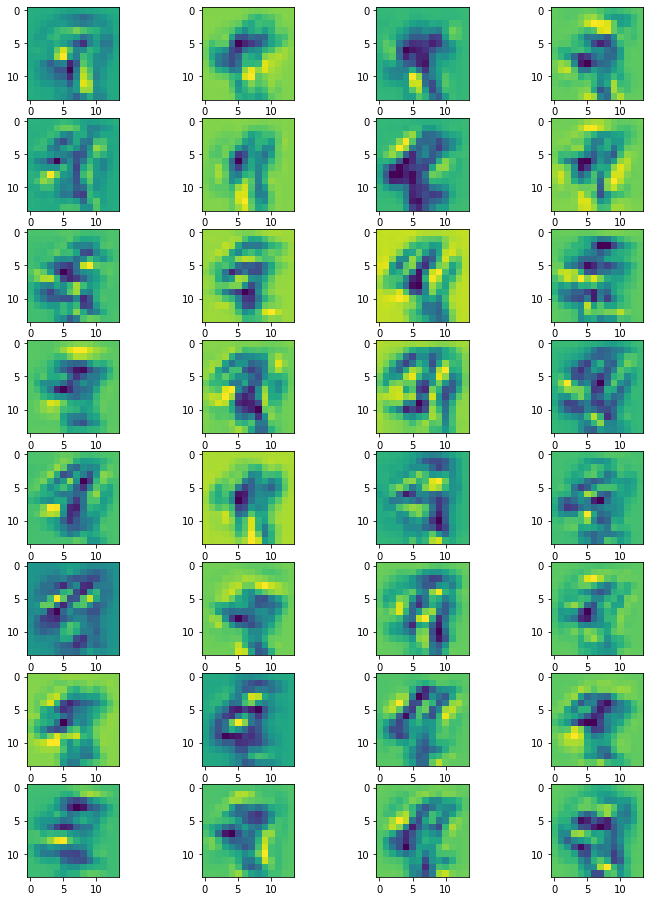

In [23]:
# We visualize the feature maps obtained for an image in the second conv layer

model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = model(data)
act = activation['conv2'].squeeze()

fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(12, 16))
k=0
for i in range(act.size(0)//4):
        for j in range(4):
          axarr[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1  
          plt.savefig('fm2.png')  